## Dự đoán giá lúa

### Import thư viện

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline


import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### Dữ liệu

In [57]:
#Đọc dữ liệu vào dataframe
df = pd.read_csv("./gasoline_prices.csv")
df.head()

,date,RON 95-III,RON 92-II
0,8/22/2018,21.17,19.61
1,8/23/2018,21.17,19.61
2,8/24/2018,21.17,19.61
3,8/25/2018,21.17,19.61
4,8/26/2018,21.17,19.61


In [58]:
#Chuyển cột date trong df thành đối tượng datetime
df['date'] = pd.to_datetime(df['date'])

#Tạo df_gasolinePrices từ df với 'date', 'RON 95-III' và đặt 'date' làm index.
df = df.loc[::3, ['date', 'RON 95-III']]
df['price'] = df['RON 95-III']
df.set_index('date', inplace=True)


In [59]:
df = df.drop('RON 95-III', axis=1)

In [60]:
df.head()

,price
date,
2018-08-22,21.17
2018-08-25,21.17
2018-08-28,21.17
2018-08-31,21.17
2018-09-03,21.17


In [122]:
df.to_csv('./df_oil.csv')

### EDA

In [61]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2018-08-22    False
2018-08-25    False
2018-08-28    False
2018-08-31    False
2018-09-03    False
              ...  
2023-10-31    False
2023-11-03    False
2023-11-06    False
2023-11-09    False
2023-11-12    False
Name: price, Length: 637, dtype: bool

In [62]:
dataset = df.copy()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

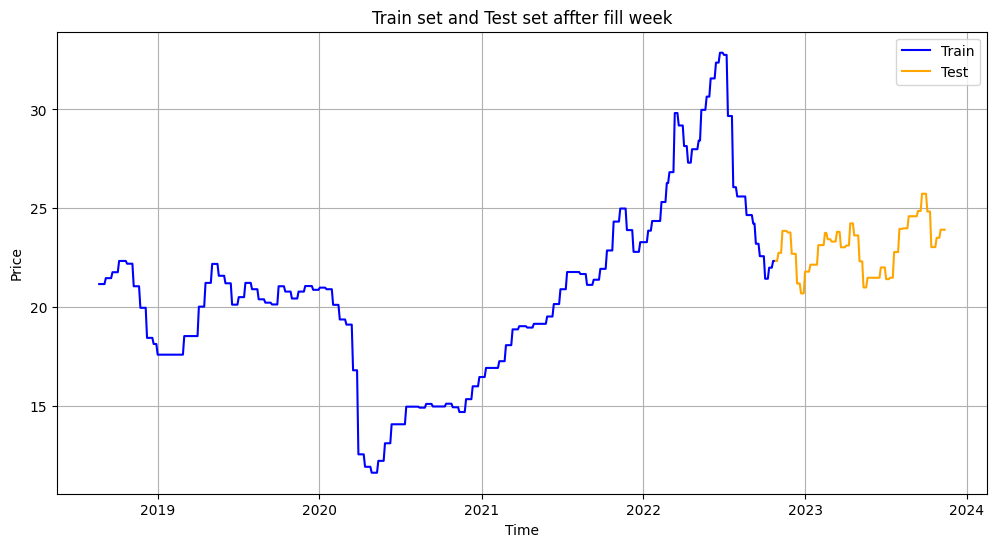

In [63]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train_data['price'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test_data['price'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set affter fill week')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [64]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [65]:
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (509, 1)
Test data shape:  (128, 1)


In [66]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset(X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 12
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (497, 12)
y_train.shape:  (497, 1)
X_test.shape:  (116, 12)
y_test.shape:  (116, 1)


In [67]:
def predict_model(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [103]:
def predict_model_oil(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction

In [68]:
def evaluate_predict(model, x, y, name_model):

    y_pred = model.predict(x)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_label = scaler.inverse_transform(y)

    # Evaluate the model
    mse = mean_squared_error(y_label, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_label, y_pred)
   
    print("Đánh giá mô hình " + name_model)
    df_eval = pd.DataFrame(data= {'MSE': [mse], 'RMSE': [rmse], "R2": [r2]})
    return df_eval

In [69]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 12
X_rnn_train, y_rnn_train = create_dataset(train_scaled, look_back)
X_rnn_test, y_rnn_test = create_dataset(test_scaled, look_back)

In [70]:
def plot_future(prediction, model_name, y_plot_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    y_plot_test =  scaler.inverse_transform(y_plot_test)
    plt.plot(np.arange(range_future), np.array(y_plot_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
       

### LSTM

In [71]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True, 
                            input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

### GRU

In [72]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = (X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
      # Hidden layer
    model.add(GRU (units = units,  return_sequences=True))                
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = units))                        
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [73]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, shuffle = False)
    return history

In [74]:
history_gru = fit_model(model_gru)

Epoch 1/100


16/16 [==============================] - 6s 14ms/step - loss: 0.0333
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0095
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0060
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0050
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0076
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0126
Epoch 8/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0094
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 10/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0036
Epoch 11/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0063
Epoch 13/100
16/16 [=================

In [75]:
history_lstm = fit_model(model_lstm)

Epoch 1/100


16/16 [==============================] - 7s 19ms/step - loss: 0.0408
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0158
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0298
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0126
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0080
Epoch 6/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0108
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0129
Epoch 8/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0080
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0060
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0072
Epoch 11/100
16/16 [==============================] - 0s 30ms/step - loss: 0.0082
Epoch 12/100
16/16 [==============================] - 0s 30ms/step - loss: 0.0068
Epoch 13/100
16/16 [=================

In [76]:
evaluate_predict(model_gru, X_rnn_train, y_rnn_train, 'GRU trên tập train').head()

16/16 [==============================] - 2s 6ms/step
Đánh giá mô hình GRU trên tập train


,MSE,RMSE,R2
0,0.711753,0.843654,0.964253


In [77]:
evaluate_predict(model_gru, X_rnn_test, y_rnn_test, 'GRU trên tập test').head()

4/4 [==============================] - 0s 10ms/step
Đánh giá mô hình GRU trên tập test


,MSE,RMSE,R2
0,0.728796,0.853696,0.531795


In [78]:
evaluate_predict(model_lstm, X_rnn_train, y_rnn_train, 'LSMT trên tập train').head()

16/16 [==============================] - 2s 6ms/step
Đánh giá mô hình LSMT trên tập train


,MSE,RMSE,R2
0,0.308722,0.555627,0.984495


In [79]:
evaluate_predict(model_lstm, X_rnn_test, y_rnn_test, 'LSTM trên tập test').head()

4/4 [==============================] - 0s 6ms/step
Đánh giá mô hình LSTM trên tập test


,MSE,RMSE,R2
0,0.419241,0.647488,0.730665


16/16 [==============================] - 0s 3ms/step


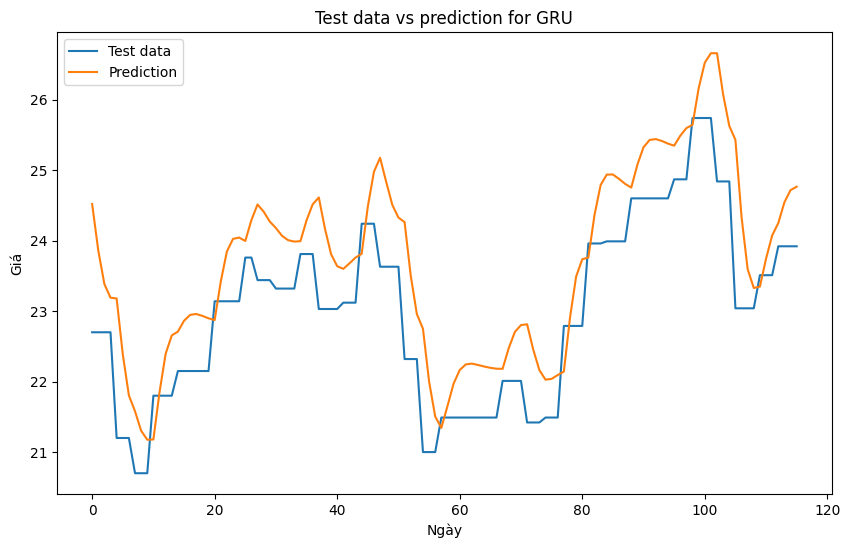

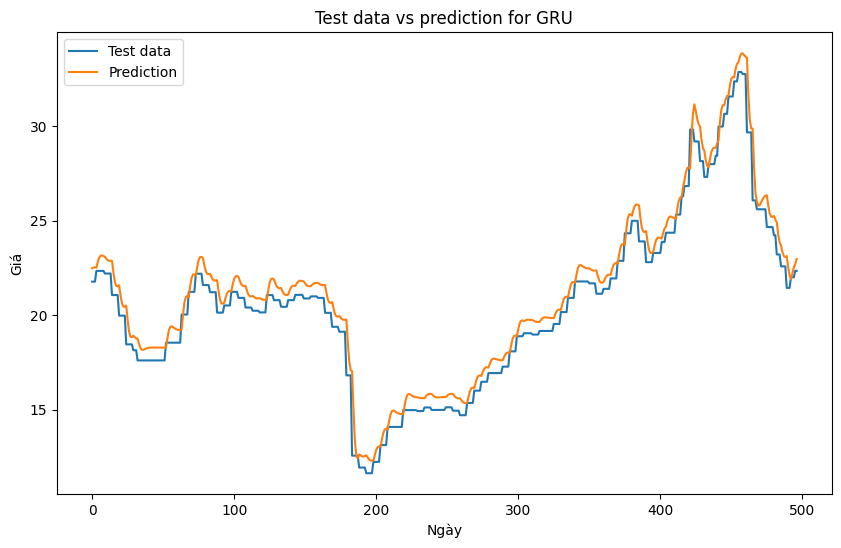

In [80]:
plot_future(predict_model(model_gru, X_rnn_test), 'GRU', y_rnn_test)
plot_future(predict_model(model_gru, X_rnn_train), 'GRU', y_rnn_train)

16/16 [==============================] - 0s 6ms/step


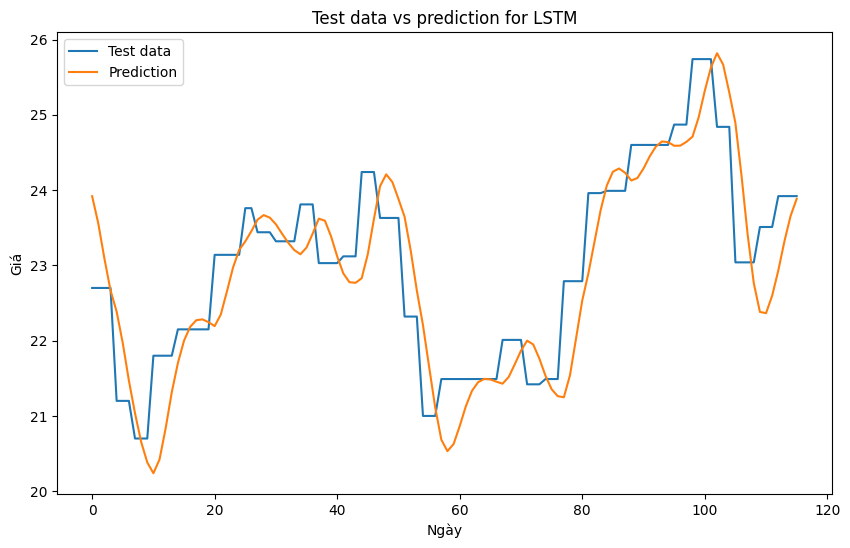

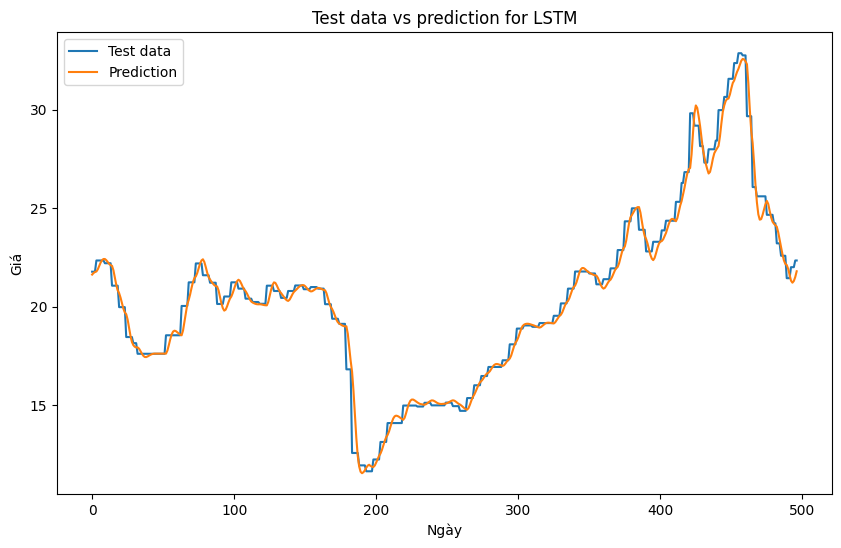

In [81]:
plot_future(predict_model(model_lstm, X_rnn_test), 'LSTM', y_rnn_test)
plot_future(predict_model(model_lstm, X_rnn_train), 'LSTM', y_rnn_train)

### Dự đoán 

In [82]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

def predict_new_date(model, days, timestep):
  forecast_num = 12 #number of day to predict after the last date in data
  forecast=predict(days, model=model,data=X_rnn_test[-1:],look_back=timestep)
  forecast_date=predict_dates(forecast_num, df)
  return scaler.inverse_transform(forecast.reshape(-1, 1))

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


Text(0, 0.5, 'Giá')

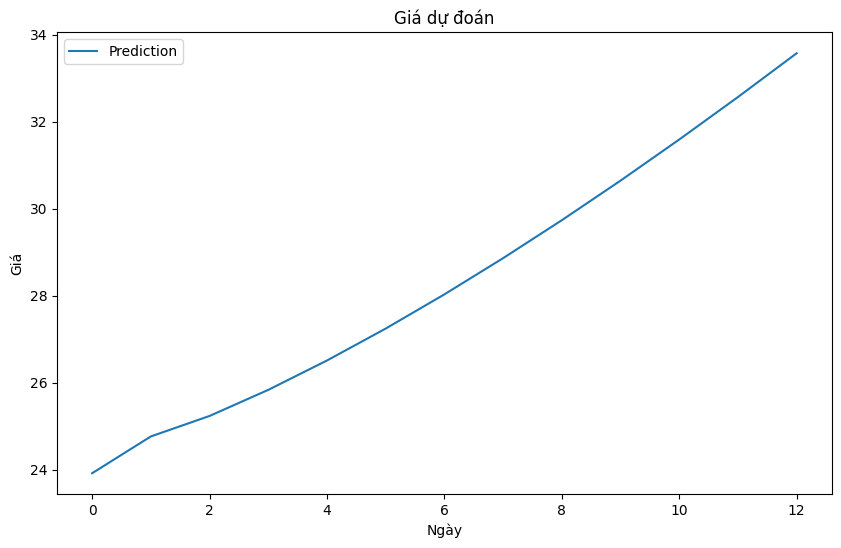

In [83]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_gru, 12, 12)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá dự đoán')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

1/1 [==============================] - 0s 20ms/step


Text(0, 0.5, 'Giá')

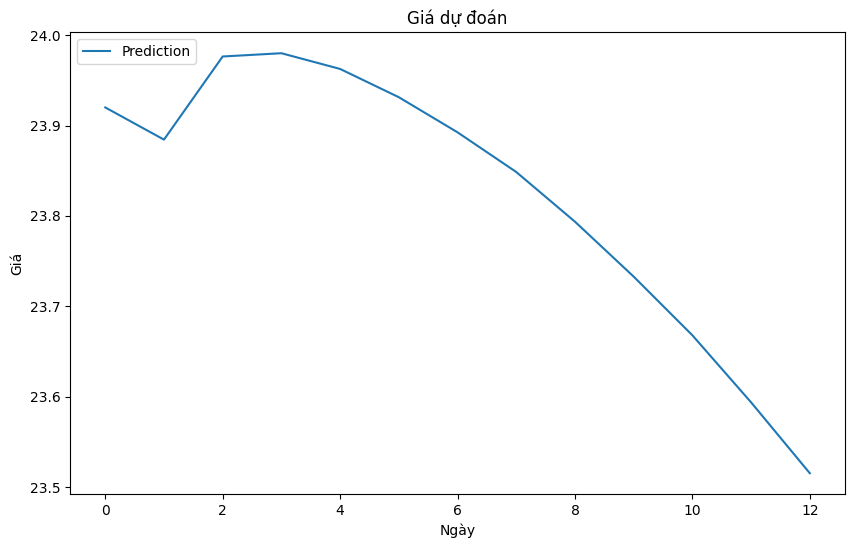

In [84]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_lstm, 12, 12)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá dự đoán')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

### Model XGBoost

In [85]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [86]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=4, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )


model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
evaluate_predict(model_xgb, X_train_xgb, y_train_xgb, 'XGBoost trên tập train').head()

Đánh giá mô hình XGBoost trên tập train


,MSE,RMSE,R2
0,0.074769,0.273439,0.996245


In [88]:
evaluate_predict(model_xgb, X_test_xgb, y_test_xgb, 'XGBoost trên tập test').head()

Đánh giá mô hình XGBoost trên tập test


,MSE,RMSE,R2
0,0.255844,0.50581,0.835637


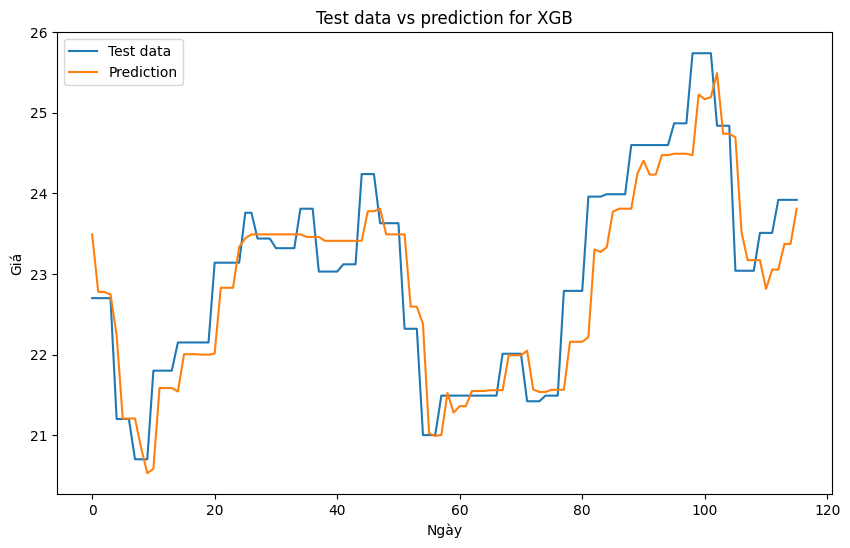

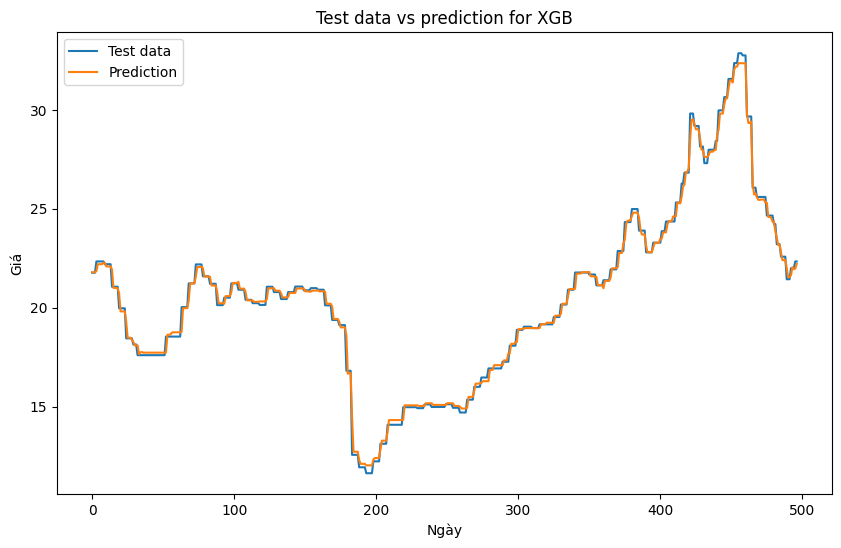

In [105]:
plot_future(predict_model_oil(model_xgb, X_test), 'XGB', y_test)
plot_future(predict_model_oil(model_xgb, X_train), 'XGB', y_train)

In [89]:
# DỰ ĐOÁN NGÀY TIẾP THEO
def predict_new_day(model, days, timesteps):
    df_pre = df.copy()
    df_pre_transform = scaler.transform(df_pre)

    # Lấy dữ liệu cuối cùng từ tập dữ liệu
    last_data = df_pre_transform[-timesteps:]
    last_data = last_data.reshape(1, -1)[:, -(timesteps - 1):]

    predicted_prices = []
    for day in range(days):
        next_prediction = model.predict(last_data)
        last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
        predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
        predicted_prices.append(predicted_price[0, 0])
        
    last_date = df_pre.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

    predicted_df = pd.DataFrame(index = future_dates, columns=['price'])

    for day, price in enumerate(predicted_prices, start=1):
        predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

    df_pre = pd.concat([df_pre, predicted_df], axis=0)
    return df_pre, predicted_df

In [90]:
timesteps = 13

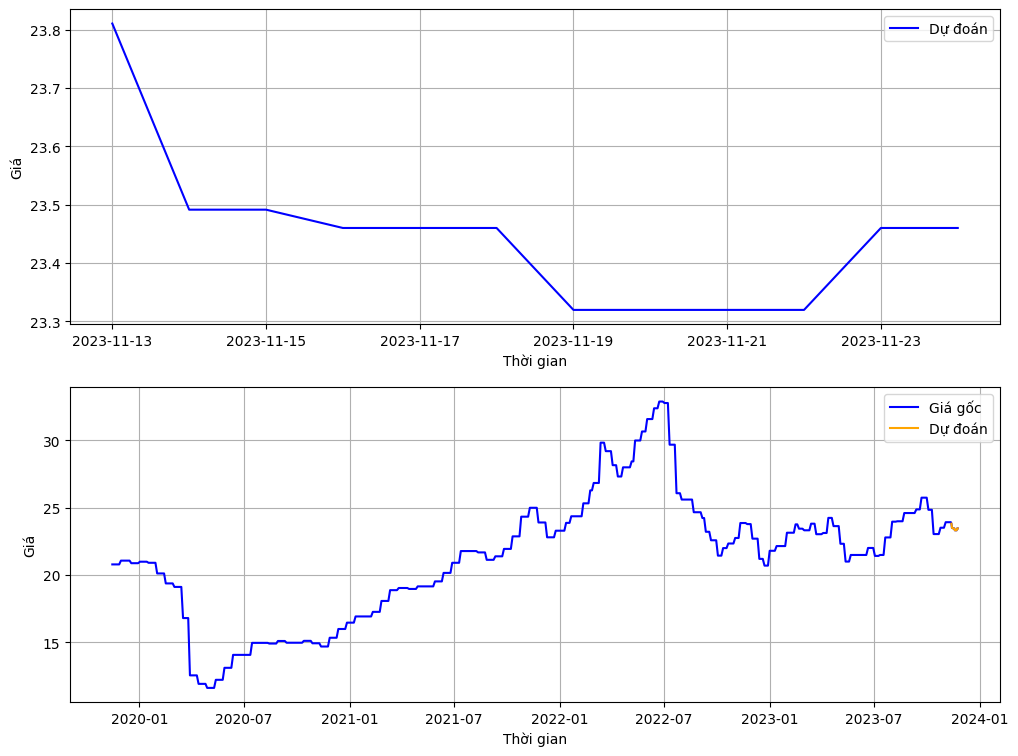

In [91]:
def plot_pred_data(model, day, timesteps):
    predicted_df_xgb, predicted_df = predict_new_day(model, day, timesteps)

    figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 9)) 

    ax1.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='blue')

    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Giá')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(predicted_df_xgb[150:].index, predicted_df_xgb[150:]['price'], label='Giá gốc', color='blue')
    ax2.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='orange')

    ax2.set_xlabel('Thời gian')
    ax2.set_ylabel('Giá')
    ax2.legend()
    ax2.grid(True)

    # Hiển thị biểu đồ
    plt.show()

plot_pred_data(model_xgb, 12, timesteps)

### Random Forest

In [92]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

In [93]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=5, random_state=0)

model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, n_estimators=60, random_state=0)

In [94]:
evaluate_predict(model_rf, X_train_rf, y_train_rf, 'Random forest trên tập train').head()

Đánh giá mô hình Random forest trên tập train


,MSE,RMSE,R2
0,0.117033,0.342101,0.994122


In [95]:
evaluate_predict(model_rf, X_test_rf, y_test_rf, 'Random forest trên tập test').head()

Đánh giá mô hình Random forest trên tập test


,MSE,RMSE,R2
0,0.2054,0.453211,0.868044


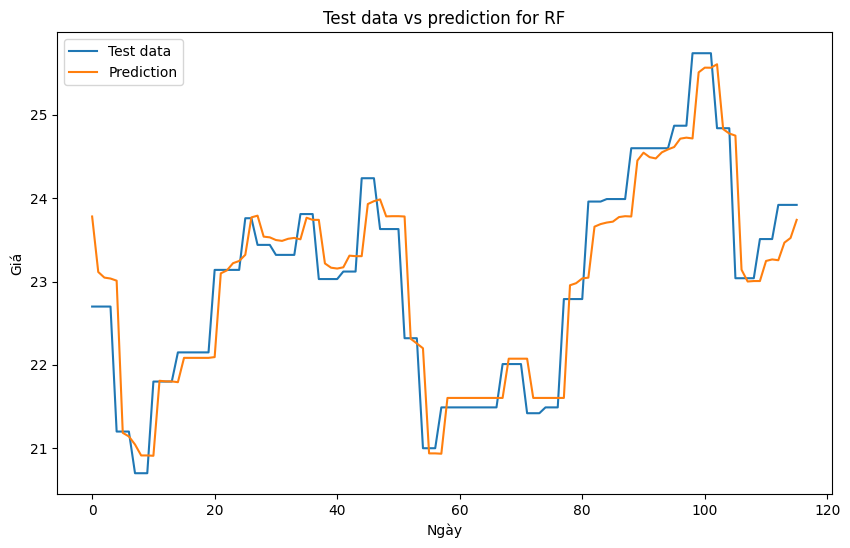

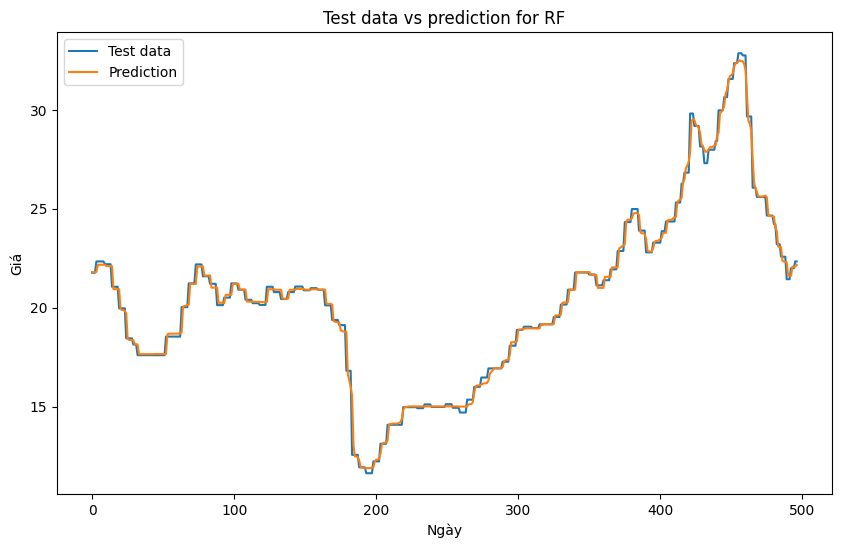

In [106]:
plot_future(predict_model_oil(model_rf, X_test), 'RF', y_test)
plot_future(predict_model_oil(model_rf, X_train), 'RF', y_train)

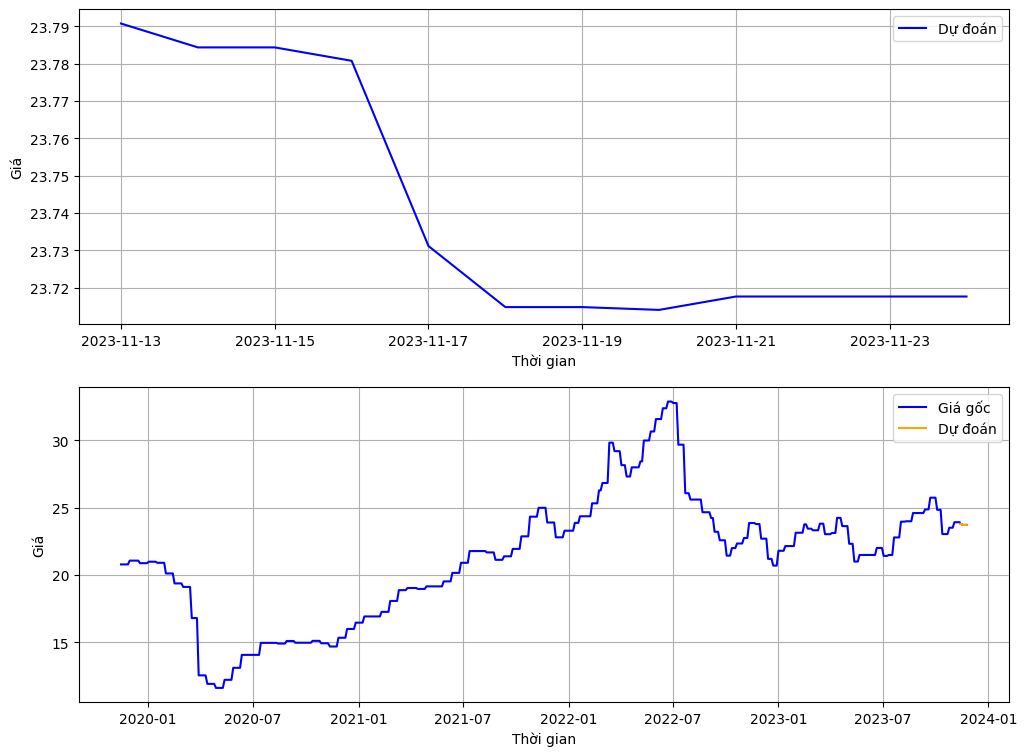

In [96]:
plot_pred_data(model_rf, 12, timesteps)

In [97]:
# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

NameError: name 'grid' is not defined

### SVM

In [107]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

In [108]:
model_svm = SVR(C=100, epsilon=0.01, gamma='auto', kernel= 'rbf')

model_svm.fit(X_train_svm, y_train_svm)

SVR(C=100, epsilon=0.01, gamma='auto')

In [100]:


# from sklearn.model_selection import GridSearchCV 
  
# # defining parameter range 
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': ['auto'], 
#               'kernel': ['rbf'],
#                'epsilon': [0.01, 0.05, 0.1, 0.5]}  
  
# grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
  
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 

In [101]:
# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

NameError: name 'grid' is not defined

In [109]:
evaluate_predict(model_svm, X_train_svm, y_train_svm, 'SVM trên tập train').head()

Đánh giá mô hình SVM trên tập train


,MSE,RMSE,R2
0,0.175044,0.418383,0.991209


In [110]:
evaluate_predict(model_svm, X_test_svm, y_test_svm, 'SVM trên tập test').head()

Đánh giá mô hình SVM trên tập test


,MSE,RMSE,R2
0,0.213553,0.462118,0.862806


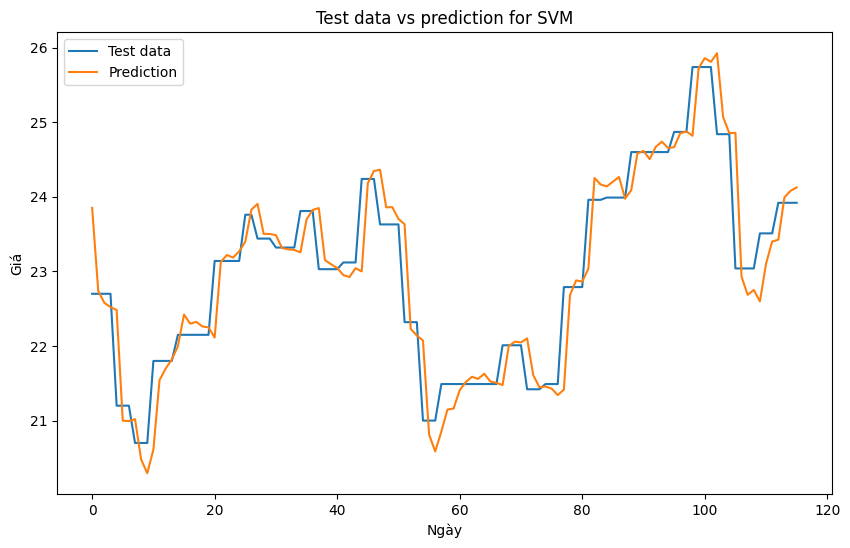

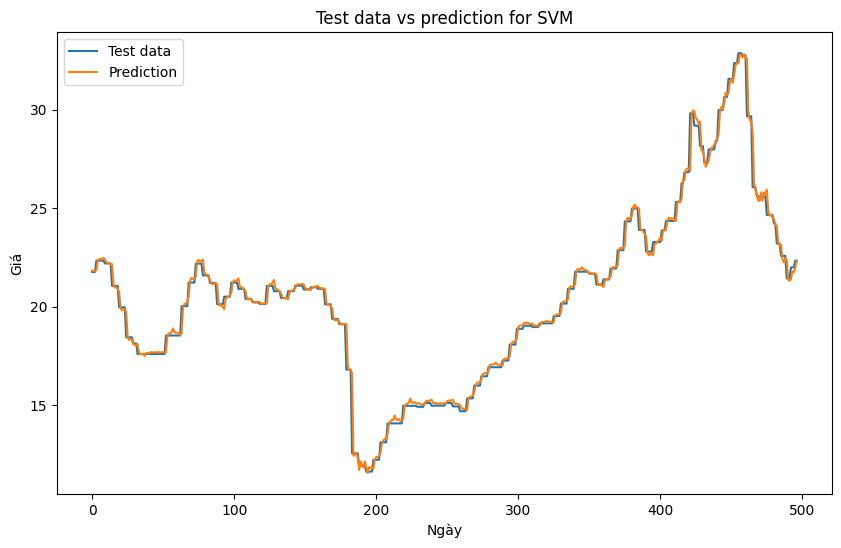

In [112]:
plot_future(predict_model_oil(model_svm, X_test), 'SVM', y_test)
plot_future(predict_model_oil(model_svm, X_train), 'SVM', y_train)

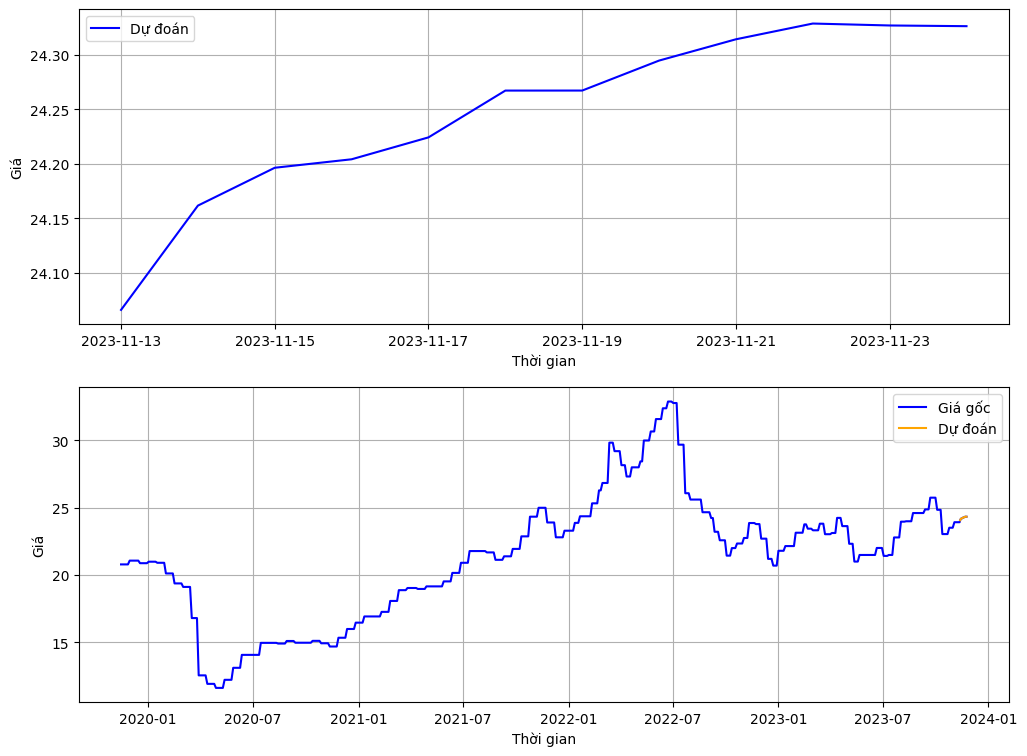

In [111]:
plot_pred_data(model_svm, 12, timesteps)

In [117]:
import joblib

# save the model to a file
joblib.dump(model_lstm, './oil/model_lstm.joblib')
joblib.dump(model_gru, './oil/model_gru.joblib')
joblib.dump(model_xgb, './oil/model_xgboost.joblib')
joblib.dump(model_rf, './oil/model_randomforest.joblib')
joblib.dump(model_svm, './oil/model_svm.joblib')



['./oil/model_svm.joblib']

In [119]:
reconstructed_model = joblib.load('./oil/model_svm.joblib')


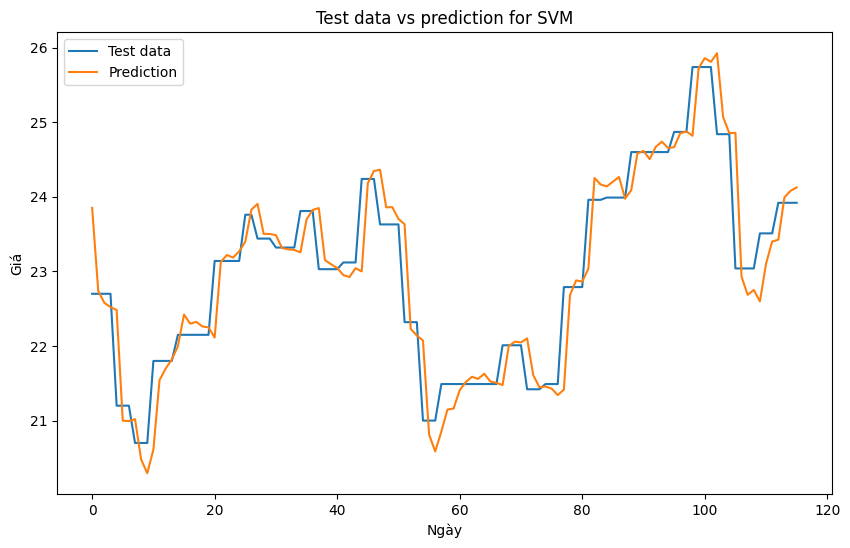

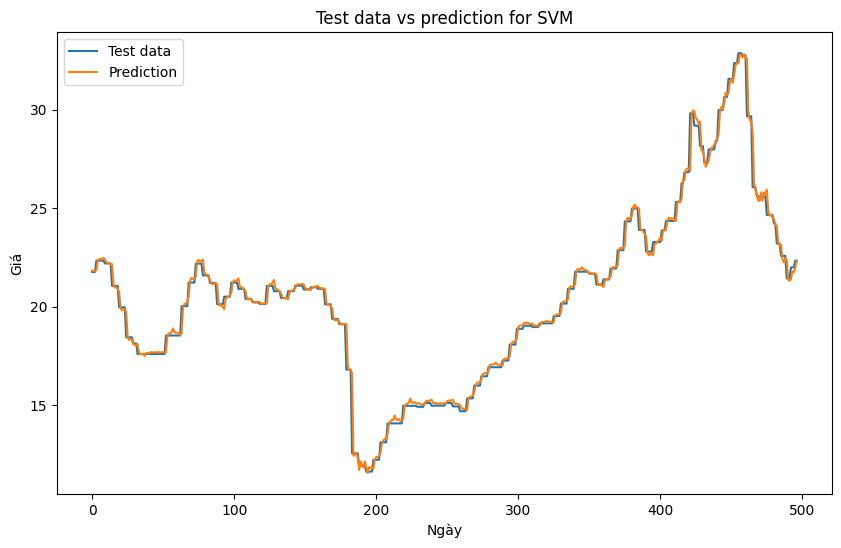

In [120]:
plot_future(predict_model_oil(reconstructed_model, X_test), 'SVM', y_test)
plot_future(predict_model_oil(reconstructed_model, X_train), 'SVM', y_train)

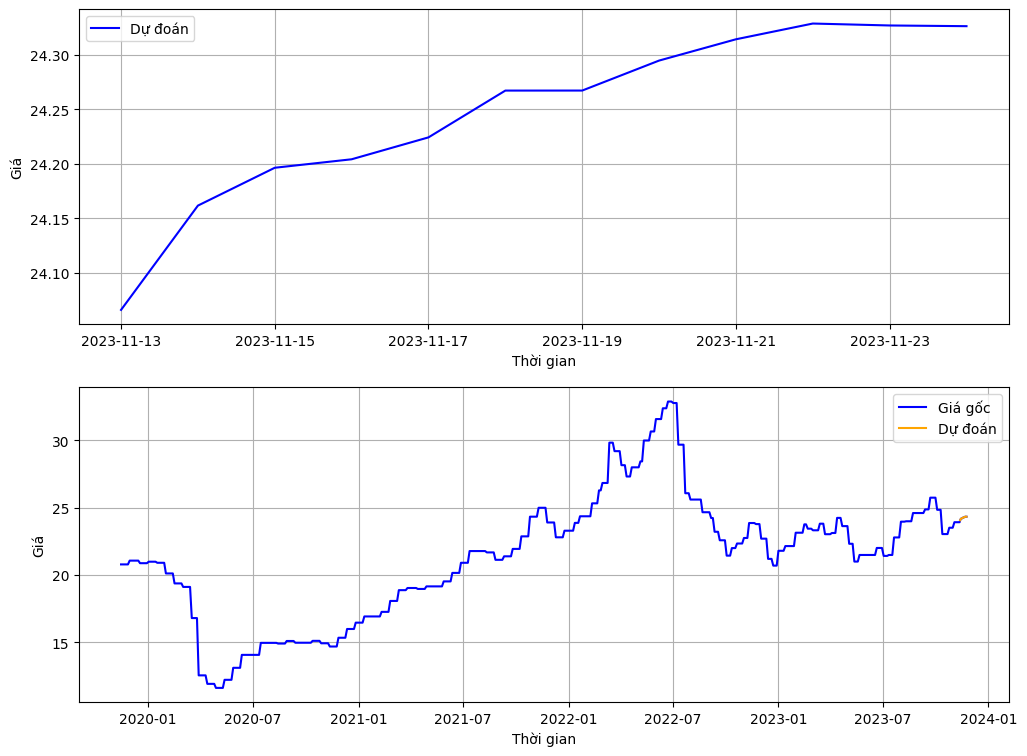

In [121]:
plot_pred_data(reconstructed_model, 12, timesteps)